In [33]:
import autokeras as ak
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.autograd import Function
from tensorflow.keras.models import load_model
import tensorflow as tf
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as trn
import torchvision.transforms.functional as trn_F
import cv2
from sklearn.metrics import accuracy_score, f1_score

Using TensorFlow backend


In [5]:
data_flag = 'pneumoniamnist'
download = True

#NUM_EPOCHS = 3
#BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_dataset = DataClass(split = 'val', transform = data_transform, download = download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

100%|███████████████████████████████████████████████████████████████████| 4170669/4170669 [00:01<00:00, 2545547.18it/s]

Using downloaded and verified file: C:\Users\chube\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\chube\.medmnist\pneumoniamnist.npz


In [6]:
x_train = train_dataset.imgs
x_val = validation_dataset.imgs
x_test = test_dataset.imgs

In [7]:
y_train = train_dataset.labels.reshape((len(train_dataset.labels),))
y_val   = validation_dataset.labels.reshape((len(validation_dataset.labels),))
y_test  = test_dataset.labels.reshape((len(test_dataset.labels),))

In [8]:
proportion = [0.2, 0.4, 0.6, 0.8, 1]
num_train  = len(y_train)
num_test   = len(y_test)
num_iter   = 1000
perturbs   = ['noise', 'contrast', 'rotate', 'tilt', 'blur']

In [24]:
def rotate(img, deg):
    img = Image.fromarray(img)
    if img.mode != 'L':
        img = img.convert('L')
    z = trn.CenterCrop(28)(trn_F.affine(img, angle=deg-15, translate=(0, 0), scale=1., shear=0))
    return z

In [10]:
def disk(radius, alias_blur=0.1, dtype=np.float32):
    if radius <= 8:
        L = np.arange(-8, 8 + 1)
        ksize = (3, 3)
    else:
        L = np.arange(-radius, radius + 1)
        ksize = (5, 5)
    X, Y = np.meshgrid(L, L)
    aliased_disk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    aliased_disk /= np.sum(aliased_disk)

    # supersample disk to antialias
    return cv2.GaussianBlur(aliased_disk, ksize=ksize, sigmaX=alias_blur)

In [11]:
def tilt(img, deg):
    x = np.array(img)
    h, w = x.shape[0:2]
    phi, theta = np.deg2rad(deg-15), np.deg2rad(deg-15)
    f = np.sqrt(w**2+h**2)
    P1 = np.array([[1,0,-w/2], [0,1,-h/2], [0,0,1], [0,0,1]])
    RX = np.array([[1,0,0,0], [0, np.cos(theta), -np.sin(theta), 0],
                  [0, np.sin(theta), np.cos(theta), 0], [0, 0, 0, 1]])
    RY = np.array([[np.cos(phi), 0, -np.sin(phi), 0], [0,1,0,0],
                  [np.sin(phi), 0, np.cos(phi), 0], [0, 0, 0, 1]])
    T = np.array([[1, 0, 0, 0], [0, 1, 0, 0],
                   [0, 0, 1, f], [0, 0, 0, 1]])
    P2 = np.array([[f, 0, w / 2, 0], [0, f, h / 2, 0], [0, 0, 1, 0]])
    mat = P2 @ T @ RX @ RY @ P1
    z = trn.CenterCrop(28)(Image.fromarray(cv2.warpPerspective(x, mat, (w, h))))
    return z

In [12]:
def contrast(img, factor, dim = 2):
    
    if dim == 3:
        num = img.shape[0]
        temp = np.zeros((num,img.shape[1], img.shape[2]))
        for i in range(num):
            tempi = img[i,:,:]
            im = Image.fromarray(tempi)
            if im.mode != 'L':
                im = im.convert('L')
            enhancer = ImageEnhance.Contrast(im)
            im_output = enhancer.enhance(factor)
            im_array = np.asarray(im_output)
            temp[i,:,:] = im_array
        return temp
    else:
        if type(img) == np.ndarray:
            im = Image.fromarray(img)
        else:
            im = img
        if im.mode != 'L':
            im = im.convert('L')
        enhancer = ImageEnhance.Contrast(im)
        im_output = enhancer.enhance(factor)
        im_array = np.asarray(im_output)
        return im_array

C:\Users\Egg\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1135: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  warnings.warn(


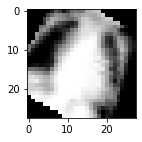

In [154]:
image = contrast(x_test[0],3)
plot(rotate(image, 45))

In [13]:
def defocus_blur(x, severity=1):
    c = [(3, 0.1), (4, 0.5), (6, 0.5), (8, 0.5), (10, 0.5)][severity - 1]

    x = np.array(x) / 255.
    kernel = disk(radius=c[0], alias_blur=c[1])

    channels = []
    channels.append(cv2.filter2D(x[:, :], -1, kernel))
    channels = np.array(channels).transpose((1, 2, 0))  # 3x224x224 -> 224x224x3
    output = np.clip(channels, 0, 1) * 255
    output = output.reshape((28,28))
    return output

In [14]:
x_test.shape

(624, 28, 28)

In [15]:
def gaussian_noise(x, c):
    #c =[0.02, 0.04, 0.06, 0.08, 0.1][severity - 1]
    
    x = np.array(x)/255
    np.random.seed(2)
    x = np.clip(x+ np.random.normal(size = x.shape, scale = c), 0, 1 * 255)
    return x.astype(np.float32)

In [16]:
def plot(img):
    plt.figure(figsize = (2,2))
    plt.imshow(img, cmap = "gray")
    plt.show()

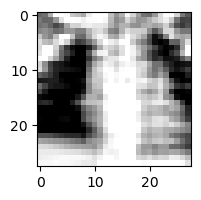

In [17]:
from PIL import Image, ImageEnhance
img = x_test[1]
im = Image.fromarray(img)
enhancer = ImageEnhance.Contrast(im)

factor = 3 #gives original image
im_output = enhancer.enhance(factor)
plt.figure(figsize = (2,2))
plt.imshow(im_output, cmap = "gray")
plt.show()
#im_output.save('original-image.png')

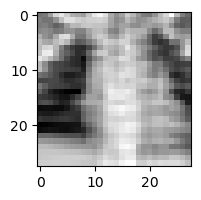

In [18]:
plot(img)

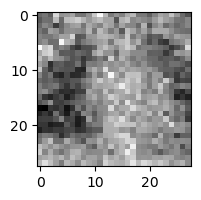

In [19]:
plot(gaussian_noise(img, 0.08))

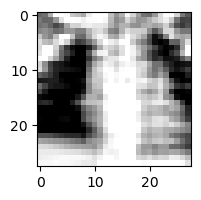

In [20]:
plot(contrast(img, 3))

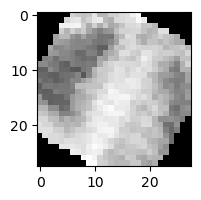

In [25]:
plot(rotate(img, deg = 45))

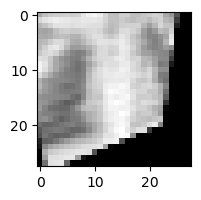

In [22]:
plot(tilt(img, deg = 45))

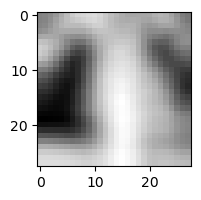

In [23]:
plot(defocus_blur(img))

In [26]:
num_perturb = 471
x_train.shape[0]

4708

In [27]:
import itertools
from pprint import pprint
import random

def random_generator(seq, n, m):
    rand_seq = seq[:]  # make a copy to avoid changing input argument
    random.shuffle(rand_seq)
    lists = []
    limit = n-1
    for i,group in enumerate(zip(*([iter(rand_seq)]*m))):
        lists.append(group)
        if i == limit: break  # have enough
    return lists

words = np.arange(x_train.shape[0])
perturb_idxs = random_generator(words, 5, 471)

In [29]:
def perturb_data(samples, idx_corrupt, variant):
    
    num_total = samples.shape[0]
    temp_set = np.zeros((samples.shape))
    img_shape = samples[0].shape
    
    if variant == 'noise':
        for k in range(num_total):
            img = samples[k]
            if k in idx_corrupt:
                temp = gaussian_noise(img, 0.08)
                temp_set[k] = temp*255
            else:
                temp = np.copy(img)
                temp_set[k] = temp
                
    if variant == 'contrast':
        for k in range(num_total):
            img = samples[k]
            if k in idx_corrupt:
                temp = contrast(img, 3)
                temp_set[k] = temp
            else:
                temp = np.copy(img)
                temp_set[k] = temp
    
    if variant == 'tilt':
        for k in range(num_total):
            img = samples[k]
            np.random.seed(k**2)
            angle = np.random.randint(0, high = 90)
            
            if k in idx_corrupt:
                temp = tilt(img, angle)
                temp_set[k] = temp
            else:
                temp = np.copy(img)
                temp_set[k] = temp
    
    if variant == 'blur':
        for k in range(num_total):
            img = samples[k]
            if k in idx_corrupt:
                temp = defocus_blur(img, severity = 1).reshape((28,28))
                temp_set[k] = temp
            else:
                temp = np.copy(img)
                temp_set[k] = temp
    
    if variant == 'rotate':
        for k in range(num_total):
            img = samples[k]
            np.random.seed(k)
            angle = np.random.randint(-90, high = 90)
            if k in idx_corrupt:
                temp        = rotate(img, angle)
                temp_set[k] = temp
            else:
                temp = np.copy(img)
                temp_set[k] = temp

    return temp_set

In [ ]:
# all_perturb_idxs = np.concatenate((perturb_idxs[0], perturb_idxs[1], perturb_idxs[2], perturb_idxs[3], perturb_idxs[4]))
# print(all_perturb_idxs.shape)

# all_idxs = np.arange(x_train.shape[0])
# no_noise_idxs = [item for item in all_idxs if item not in all_perturb_idxs]
# no_noise_idxs = np.array(no_noise_idxs)
# print(no_noise_idxs.shape[0] + all_perturb_idxs.shape[0] == all_idxs.shape[0])

# clean_imgs = x_train[no_noise_idxs,:,:]
# print(clean_imgs.shape)

# new_train = []
# for i in range(len(perturbs)):
#     new_train.append(perturb_data(samples = x_train[perturb_idxs[i],:,:], idx_corrupt = np.arange(x_train[perturb_idxs[0],:,:].shape[0]), variant = perturbs[i]))

# new_y = []
# new_y.append(y_train[list(perturb_idxs[0])])
# new_y.append(y_train[list(perturb_idxs[1])])
# new_y.append(y_train[list(perturb_idxs[2])])
# new_y.append(y_train[list(perturb_idxs[3])])
# new_y.append(y_train[list(perturb_idxs[4])])
# new_y.append(y_train[no_noise_idxs])
# y_new = np.concatenate((new_y[0], new_y[1], new_y[2], new_y[3], new_y[4], new_y[5]))
# print(y_new.shape)

# new_data = np.concatenate((new_train[0], new_train[1], new_train[2], new_train[3], new_train[4], clean_imgs))
# new_data.shape

# created_model_list = []
# pmodel_list = []
# for i in range(len(omodel_list)):
#     model_number = i
#     OG_model = load_model("MODEL_"+str(model_number)+"_XRAY", custom_objects = ak.CUSTOM_OBJECTS)
            
#     weights = OG_model.get_weights()
#     np.random.seed(12345)
#     weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
#     OG_model.set_weights(weights)
#     OG_model.fit(new_data, y_new, epochs = 5, batch_size = 8)
#     try:
#         OG_model.save("MODEL_"+str(model_number)+"_XRAY_"+"MIX", save_format = "tf")
#     except Exception:
#         OG_model.save("MODEL_"+str(model_number)+"_XRAY_"+"MIX.h5")
        
#     pmodel_list.append(OG_model)

In [ ]:
num_models = 10
omodel_list = []
pmodel_list = []
for i in tqdm(range(num_models)):
    omodel_list.append(load_model("MODEL_"+str(i)+"_XRAY", custom_objects = ak.CUSTOM_OBJECTS, compile = False))
    pmodel_list.append(load_model("MODEL_"+str(i)+"_XRAY_MIX", custom_objects = ak.CUSTOM_OBJECTS, compile = False))

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
num_iter = 200
pert_means = np.zeros((len(pmodel_list),))
pert_var = np.zeros((len(pmodel_list),))
cont_means = np.zeros((len(pmodel_list),))
cont_var = np.zeros((len(pmodel_list),))
for i in range(len(pmodel_list)):
    current_model = pmodel_list[i]
    unpert_model  = omodel_list[i]
    temp_pert = np.zeros((num_iter,))
    temp_cont = np.zeros((num_iter,))
    for j in tqdm(range(num_iter)):
        np.random.seed(j)
        seeds = np.random.randint(low = 0, high = 999999, size = 5)
        np.random.seed(seeds[0])
        coin_noise = np.random.randint(low = 0, high = 2, size = x_test.shape[0])
        np.random.seed(seeds[1])
        coin_contrast = np.random.randint(low = 0, high = 2, size = x_test.shape[0])
        np.random.seed(seeds[2])
        coin_rotation = np.random.randint(low = 0, high = 2, size = x_test.shape[0])
        np.random.seed(seeds[3])
        coin_tilt  = np.random.randint(low = 0, high = 2, size = x_test.shape[0])
        np.random.seed(seeds[4])
        coin_blur  = np.random.randint(low = 0, high = 2, size = x_test.shape[0])
    
        idx_noise = np.where(coin_noise == 1)[0]
        idx_contrast = np.where(coin_contrast == 1)[0]
        idx_rotation = np.where(coin_rotation == 1)[0]
        idx_tilt  = np.where(coin_tilt == 1)[0]
        idx_blur  = np.where(coin_blur == 1)[0]
    
        temp_test_set_n = perturb_data(samples = x_test, idx_corrupt = idx_noise, variant = 'noise')
        temp_test_set_c = perturb_data(samples = temp_test_set_n, idx_corrupt = idx_contrast, variant = 'contrast')
        temp_test_set_r = perturb_data(samples = temp_test_set_c, idx_corrupt = idx_rotation, variant = 'rotate')
        temp_test_set_t = perturb_data(samples = temp_test_set_r, idx_corrupt = idx_tilt, variant = 'tilt') 
        temp_test_set   = perturb_data(samples = temp_test_set_t, idx_corrupt = idx_blur, variant = 'blur')
        performance = current_model.predict(temp_test_set, verbose = 0).round()
        control     = unpert_model.predict(temp_test_set, verbose = 0).round()
    
        err_test = 1-accuracy_score(y_test, performance)
        err_cont = 1-accuracy_score(y_test, control)
        
        temp_pert[j] = err_test
        temp_cont[j] = err_cont
        
    pert_means[i] = np.mean(temp_pert)
    pert_var[i]   = np.std(temp_pert)
    cont_means[i] = np.mean(temp_cont)
    cont_var[i]   = np.std(temp_cont)
    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:23<00:00,  1.32s/it]


In [48]:
import pandas as pd
pert_df = pd.DataFrame(pert_means)
pert_df.to_csv('pert_df_xray.csv')
cont_df = pd.DataFrame(cont_means)
cont_df.to_csv('cont_df_xray.csv')

Text(0, 0.5, 'Error Rate (1-Accuracy)')

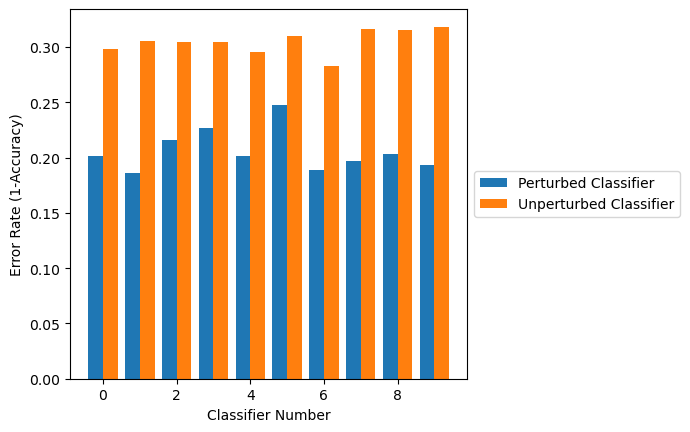

In [51]:
import matplotlib.pyplot as plt
x = np.arange(10)
y1 = pert_means
y2 = cont_means
width = 0.40
fig = plt.figure()
ax = plt.subplot(111)
# plot data in grouped manner of bar type
ax.bar(x-0.2, y1, width, label = 'Perturbed Classifier')
ax.bar(x+0.2, y2, width, label = 'Unperturbed Classifier')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Classifier Number')
plt.ylabel('Error Rate (1-Accuracy)')

Text(0, 0.5, 'Error Rate (1-Accuracy)')

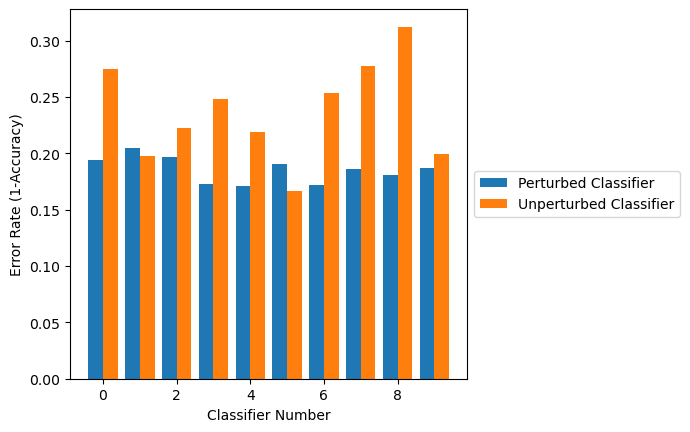

In [52]:
mean = np.zeros((10,))
mean2 = np.zeros((10,))
for i in range(10):
    df = pd.read_csv('df2_pert'+str(i)+'.csv')
    df2 = pd.read_csv('df2_cont'+str(i)+'.csv')
    mean[i] = np.mean(df.iloc[:,1].values)
    mean2[i] = np.mean(df2.iloc[:,1].values)

x = np.arange(10)
y1_1 = mean
y2_1 = mean2
width = 0.40
fig = plt.figure()
ax = plt.subplot(111)
# plot data in grouped manner of bar type
ax.bar(x-0.2, y1_1, width, label = 'Perturbed Classifier')
ax.bar(x+0.2, y2_1, width, label = 'Unperturbed Classifier')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Classifier Number')
plt.ylabel('Error Rate (1-Accuracy)')

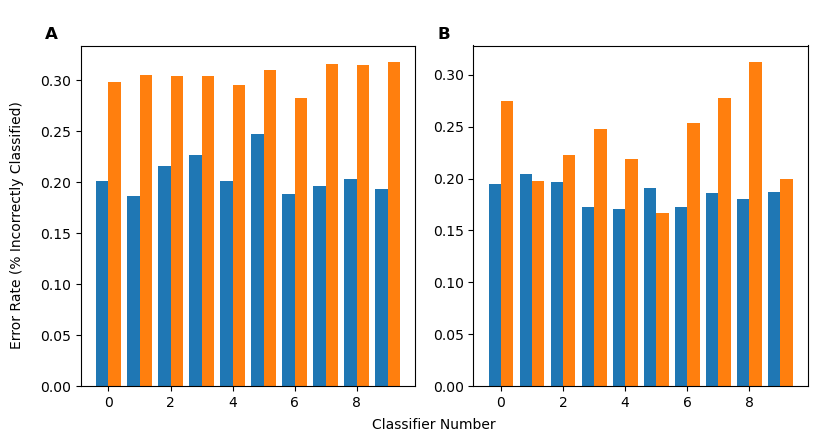

In [64]:
perturbs_capital = ['Noise', 'Contrast', 'Rotate', 'Tilt', 'Blur']
fig= plt.figure(figsize = (8,4))
gs = fig.add_gridspec(1,2)
axs = [fig.add_subplot(gs[i]) for i in range(2)]
letters = ["A","B"]

fig.canvas.draw()

fig.text(0.5, 0, 'Classifier Number', ha='center', va='center')
fig.text(-0.03, 0.5, 'Error Rate (% Incorrectly Classified)', va = 'center', rotation = 'vertical')
fig.tight_layout()

for ax, label in zip(axs, letters):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    fig.text(bbox.x0+30, bbox.y1+30, label, fontsize = 12, va = "top", ha = "left", fontweight = "bold", transform = None)

axs[0].bar(x-0.2,y1, width, label = 'Perturbed Classifier')
axs[0].bar(x+0.2,y2, width, label = 'Unperturbed Classifier')
axs[1].bar(x-0.2, y1_1, width, label = 'Perturbed Classifier')
axs[1].bar(x+0.2, y2_1, width, label = 'Unperturbed Classifier')


#fig.supylabel('Error Rate (% Incorrectly Classified)')
#fig.legend(handles, labels, loc=(0.70,0.25))
fig.savefig('Followup.png', bbox_inches = 'tight')
#fig.suptitle('Comparison of Unperturbed Classifier and 20% Perturbed Classifier Performance by Perturbation')